In [1]:
!pip install -q tensorflow_text
!pip install -q tf-models-official==2.11.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
distributed 20

In [2]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text  # Registers the ops.
from keras.utils import to_categorical
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv('/kaggle/input/labeled-unreliable-news-lun/train.csv', encoding='utf-8')
df_test = pd.read_csv('/kaggle/input/labeled-unreliable-news-lun/test.csv', encoding='utf-8')

In [4]:
df_train.head()

,label,text
0,0,"A little less than a decade ago, hockey fans w..."
1,0,The writers of the HBO series The Sopranos too...
2,0,Despite claims from the TV news outlet to offe...
3,0,After receiving 'subpar' service and experienc...
4,0,After watching his beloved Seattle Mariners pr...


In [5]:
df_test.head()

,label,text
0,0,When so many actors seem content to churn out ...
1,0,In what football insiders are calling an unex...
2,0,In a freak accident following Game 3 of the N....
3,0,North Koreas official news agency announced to...
4,0,The former Alaska Governor Sarah Palin would b...


In [6]:
TEXT_LABELS = {0: 'Satire', 1: 'Hoax', 2: 'Propaganda', 3: 'Reliable'}

In [7]:
DOWNSAMPLE = False
DOWNSAMPLE_RATIO = 0.01

if DOWNSAMPLE:
    df_train, _ = train_test_split(df_train, train_size=DOWNSAMPLE_RATIO, random_state=42, stratify=df_train['label'])
    df_test, _ = train_test_split(df_test, train_size=DOWNSAMPLE_RATIO, random_state=42, stratify=df_test['label'])

In [8]:
print('Shape of the training data: ', df_train.shape)
print('Shape of the test data: ', df_test.shape)

Shape of the training data:  (48854, 2)
Shape of the test data:  (3000, 2)


In [9]:
# Check the class distribution
df_train.groupby('label').count()

,text
label,
0,14047
1,6942
2,17870
3,9995


In [10]:
# Check the class distribution
df_test.groupby('label').count()

,text
label,
0,750
1,750
2,750
3,750


## Encode the classes

In [11]:
X_train = df_train['text']

y_train = df_train['label']
y_train = to_categorical(y_train, num_classes=4)


X_test = df_test['text']
y_test = df_test['label']
y_test = to_categorical(y_test, num_classes=4)

## BERT Model

In [12]:
# Define the optimizer which uses the same leraning rate schedule as BERT pre-training
epochs = 3
batch_size = 16
eval_batch_size = 16

train_data_size = df_train.shape[0]
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=10000,
    decay_rate=0.9)

# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')
optimizer = tfa.optimizers.LAMB(learning_rate=lr_schedule)


In [13]:
def build_model(num_classes, optimizer, max_seq_length=128):
    
    
    preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

    # Step 1: tokenize batches of text inputs.
    text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
    tokenize = hub.KerasLayer(preprocessor.tokenize)
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]

    # Step 2 (optional): modify tokenized inputs.
    pass

    # Step 3: pack input sequences for the Transformer encoder.
    seq_length = max_seq_length
    bert_pack_inputs = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length))  # Optional argument.
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
         
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.5)(net)
    out = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
    
    
    model = tf.keras.models.Model(text_inputs, out)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes, average='macro')])
    
    return model

In [14]:
model = build_model(num_classes=len(TEXT_LABELS), optimizer=optimizer, max_seq_length=256)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['keras_layer[0][0]']            
                                (None, 256),                                                      
                                 'input_mask': (Non                                               
                                e, 256),                                                      

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_checkpoint', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

history = model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          epochs=epochs, 
          callbacks=[checkpoint, early_stopping], 
          batch_size=batch_size,
          validation_batch_size=eval_batch_size,
          verbose=1)

Epoch 1/3
3054/3054 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9329 - f1_score: 0.9279
Epoch 1: val_accuracy improved from -inf to 0.60933, saving model to best_checkpoint
3054/3054 [==============================] - 1852s 594ms/step - loss: 0.1830 - accuracy: 0.9329 - f1_score: 0.9279 - val_loss: 2.1084 - val_accuracy: 0.6093 - val_f1_score: 0.5417
Epoch 2/3
3054/3054 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9940 - f1_score: 0.9935
Epoch 2: val_accuracy did not improve from 0.60933
3054/3054 [==============================] - 1796s 588ms/step - loss: 0.0199 - accuracy: 0.9940 - f1_score: 0.9935 - val_loss: 2.6496 - val_accuracy: 0.5980 - val_f1_score: 0.5194
Epoch 3/3
3054/3054 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9967 - f1_score: 0.9964
Epoch 3: val_accuracy improved from 0.60933 to 0.61200, saving model to best_checkpoint
3054/3054 [==============================] - 1815s 594ms/step - loss

In [16]:
def plot_loss(history):
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.tight_layout()

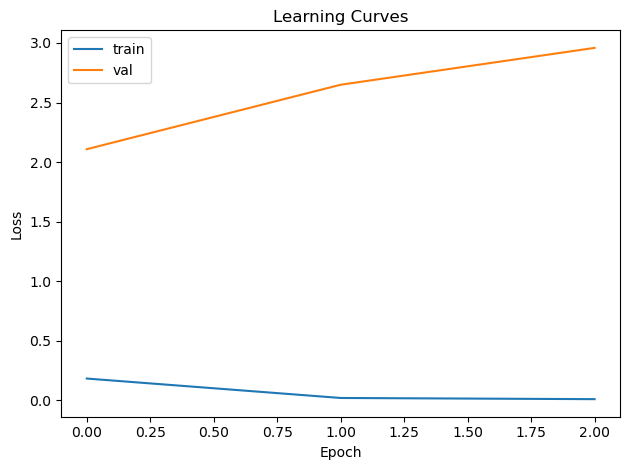

In [17]:
plot_loss(history)

In [18]:
y_proba = model.predict(X_test, batch_size=eval_batch_size)
y_pred = np.argmax(y_proba, axis=1)
y_pred_labels = [TEXT_LABELS[x] for x in y_pred]
y_true_labels = [TEXT_LABELS[x] for x in df_test['label']]

188/188 [==============================] - 39s 201ms/step


In [19]:
print(classification_report(y_true=y_true_labels, y_pred=y_pred_labels))
print(confusion_matrix(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

        Hoax       0.85      0.69      0.76       750
  Propaganda       0.13      0.03      0.05       750
    Reliable       0.46      0.99      0.63       750
      Satire       0.93      0.73      0.82       750

    accuracy                           0.61      3000
   macro avg       0.59      0.61      0.56      3000
weighted avg       0.59      0.61      0.56      3000

[[519 151  65  15]
 [  2  23 700  25]
 [  0   1 745   4]
 [ 92   3 106 549]]
